In [ ]:
pip install torch transformers

In [8]:
import torch
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def generate_segmentation_map(image_path, output_path):
    image = Image.open(image_path)

    feature_extractor = SegformerFeatureExtractor.from_pretrained('nvidia/segformer-b0-finetuned-ade-512-512')
    model = SegformerForSemanticSegmentation.from_pretrained('nvidia/segformer-b0-finetuned-ade-512-512')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    inputs = feature_extractor(images=image, return_tensors="pt")
    pixel_values = inputs["pixel_values"].to(device)

    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)
    logits = outputs.logits  

    seg_map = logits.argmax(dim=1)[0] 
    seg_map = seg_map.cpu().detach().numpy()
    seg_image_resized = Image.fromarray(seg_map.astype(np.uint8)).resize(image.size, resample=Image.NEAREST)
    seg_map_resized = np.array(seg_image_resized)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(seg_map_resized)
    plt.axis('off')
    plt.title('Segmentation Map')
    plt.show()
    
    
    cmap = plt.get_cmap('plasma') 
    normalized_seg_map = seg_map.astype(float) / np.max(seg_map)
    colored_seg_map = cmap(normalized_seg_map)
    colored_seg_map = (colored_seg_map[..., :3] * 255).astype(np.uint8)
    colored_seg_image = Image.fromarray(colored_seg_map)
    original_image = Image.open(image_path)
    original_size = original_image.size  
    resized_colored_seg_image = colored_seg_image.resize(original_size, Image.NEAREST)

    resized_colored_seg_image.save(output_path)

/tmp/ipykernel_1438928/984302387.py:37: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  seg_image_resized = Image.fromarray(seg_map.astype(np.uint8)).resize(image.size, resample=Image.NEAREST)


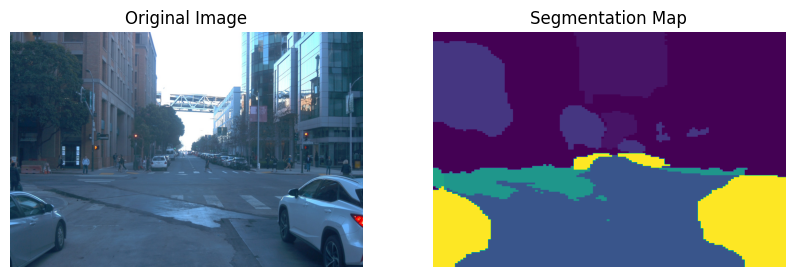

/tmp/ipykernel_1438928/984302387.py:78: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  resized_colored_seg_image = colored_seg_image.resize(original_size, Image.NEAREST)


Colored segmentation map saved to source/1.png


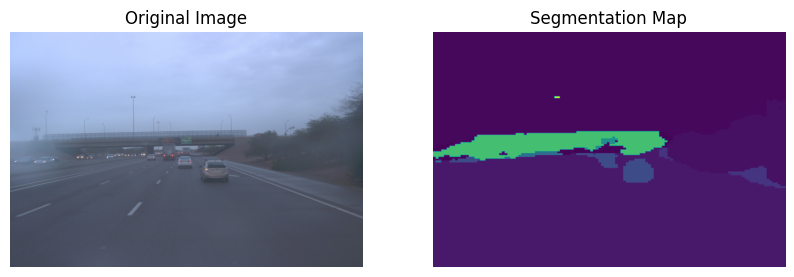

Colored segmentation map saved to source/2.png


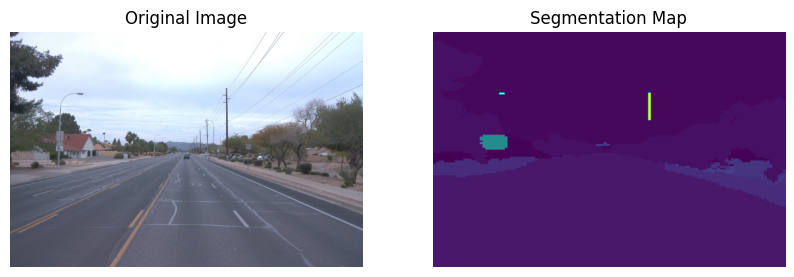

Colored segmentation map saved to source/3.png


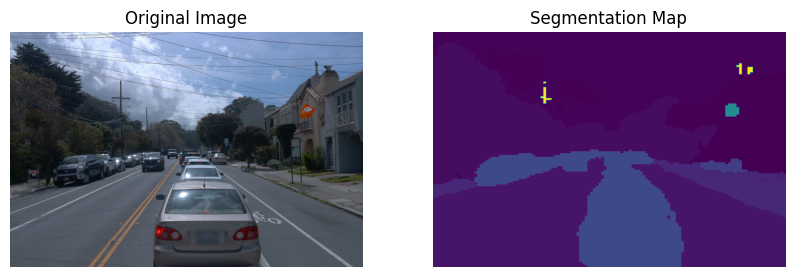

Colored segmentation map saved to source/4.png


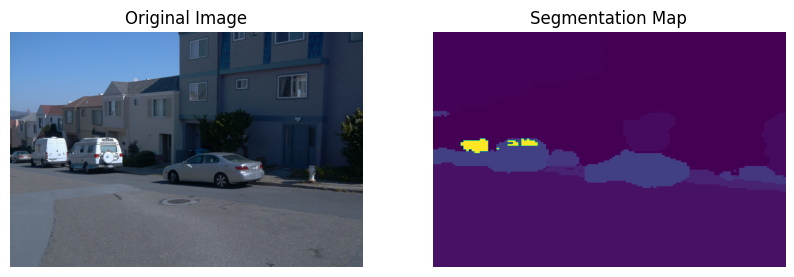

Colored segmentation map saved to source/5.png


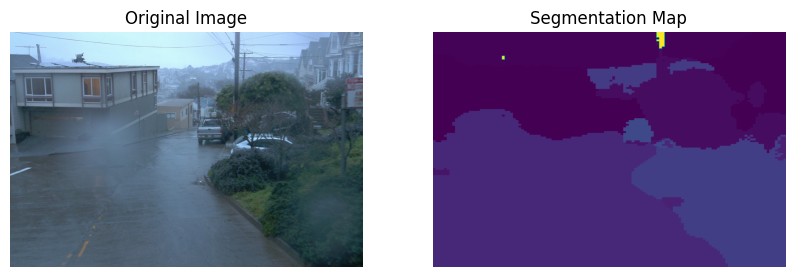

Colored segmentation map saved to source/6.png


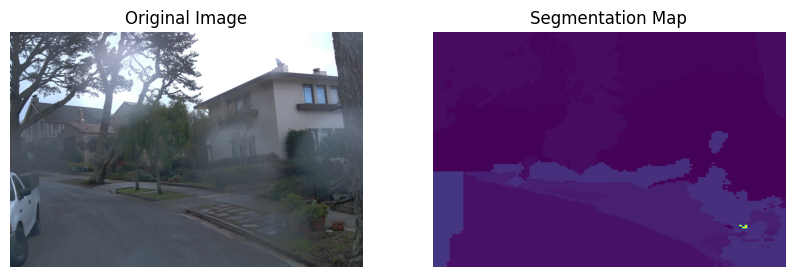

Colored segmentation map saved to source/7.png


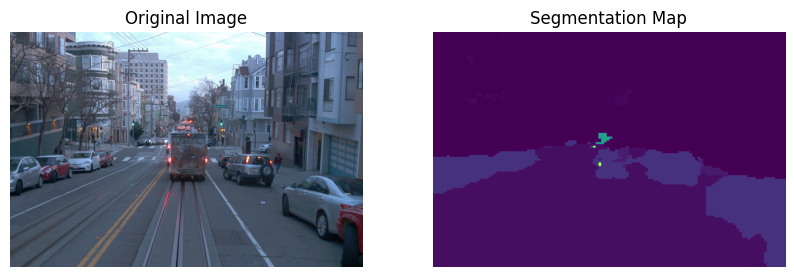

Colored segmentation map saved to source/8.png


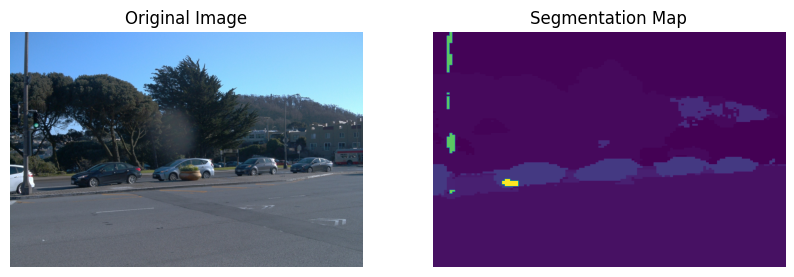

Colored segmentation map saved to source/9.png


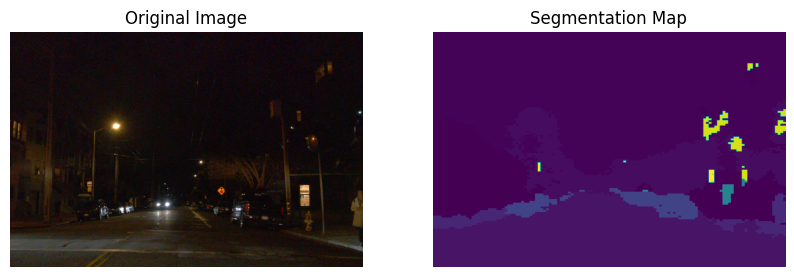

Colored segmentation map saved to source/10.png


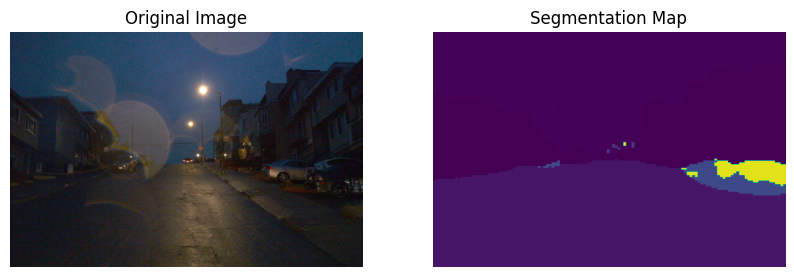

Colored segmentation map saved to source/11.png


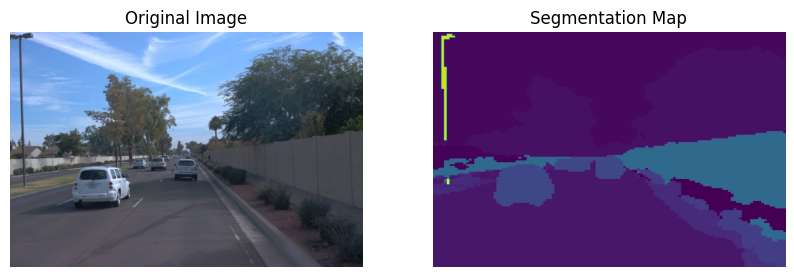

Colored segmentation map saved to source/12.png


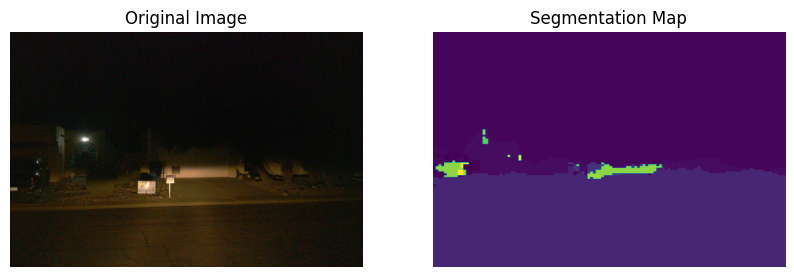

Colored segmentation map saved to source/13.png


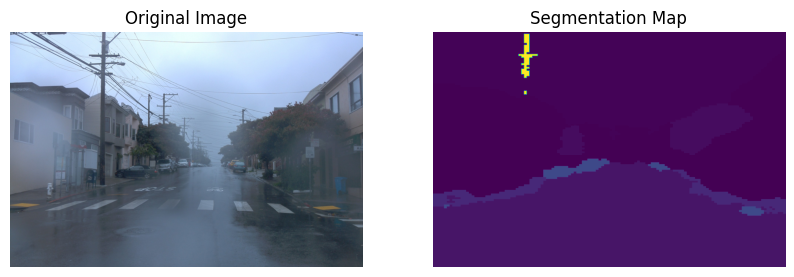

Colored segmentation map saved to source/14.png
Processed 14 images.


In [9]:
import os
import shutil
import json

image_folder = '/scratch/gpfs/ms90/waymo_images'
target_folder = 'target'
source_folder = 'source'
json_file_path = 'prompt.json'

os.makedirs(target_folder, exist_ok=True)
os.makedirs(source_folder, exist_ok=True)

mappings = []
i = 0

for filename in os.listdir(image_folder):
    if filename.endswith('.png'):
        i += 1
        target_name = f"{i}.png"
        source_name = f"{i}.png"
        
        target_path = os.path.join(target_folder, target_name)
        source_path = os.path.join(source_folder, source_name)
        
        shutil.copy(os.path.join(image_folder, filename), target_path)
        generate_segmentation_map(os.path.join(image_folder, filename), source_path)
        
        mappings.append({
            "source": os.path.join(source_folder, source_name),
            "target": os.path.join(target_folder, target_name),
            "prompt": "A roadside photo"
        })

with open(json_file_path, 'w') as json_file:
    json.dump(mappings, json_file, indent=4)
